<a href="https://colab.research.google.com/github/jobless09/Image-Segmentation-using-Xception/blob/main/car_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# Importing all the required libraries
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG
from google.colab.patches import cv2_imshow

In [37]:
import tensorflow as tf



In [38]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [129]:
class DeepLabModel(object):
  

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  # INPUT_SIZE = 1024
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef() .FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    print(width, height)
    print("Resize Ratio - {}".format(resize_ratio))
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    print(target_size)
    # target_size = (width, height)
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()



LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [101]:
# Downloading the Xception model form tensorflow site.
MODEL_NAME = 'xception_coco_voctrainval'  # @param [ 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [102]:
# Creating a function which will call the method run from previously define class.
def run_visualization():
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(IMAGE_NAME)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image')
  resized_im, seg_map = MODEL.run(original_im)
  vis_segmentation(resized_im, seg_map)
  return resized_im, seg_map

running deeplab on image
1920 1080
Resize Ratio - 0.2671875
(513, 288)


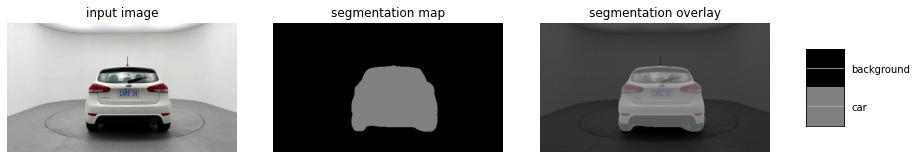

In [130]:
IMAGE_NAME = '3_30.jpg' # Passing any image.
resized_im, seg_map = run_visualization() 

In [131]:
LABEL_NAMES

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tv'], dtype='<U11')

In [132]:
LABEL_NAMES[7]

'car'

In [133]:
# let see the image type 
print(type(resized_im))


<class 'PIL.Image.Image'>


In [134]:
# Now converting Python Imaging Library Image into Numpy array
numpy_img=np.array(resized_im)

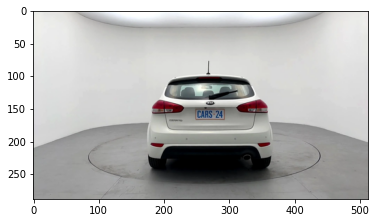

In [135]:
plt.imshow(numpy_img)

In [136]:
# Now, we will seperate foreground and background images using SegMap
segmenting_car_from_background= deepcopy(numpy_img)
# Changing pixel intensity values to 0 when it segmentation part is not found (changing background to black color)
segmenting_car_from_background[seg_map != 7]=0
segmenting_car_from_background[seg_map ==7]=255


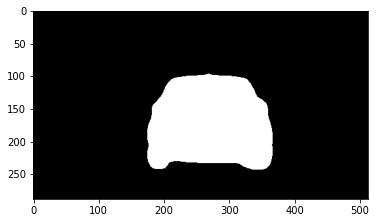

In [137]:
# visualizing image binary mask
plt.imshow(segmenting_car_from_background)

In [138]:
# now checking the unique pixels value of the segmented image
np.unique(segmenting_car_from_background)

array([  0, 255], dtype=uint8)

In [139]:
# Resizing the segmented image to the original size.
original_image=Image.open(IMAGE_NAME)
original_image=np.array(original_image)
original_image.shape#dimension of the original image.
resize_segmented_img=cv2.resize(segmenting_car_from_background,(original_image.shape[1],original_image.shape[0]),Image.ANTIALIAS)


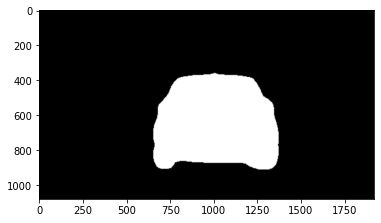

In [140]:
#visualizing resized segmented image
plt.imshow(resize_segmented_img)

In [141]:
resize_segmented_img.shape

(1080, 1920, 3)

In [142]:
np.unique(resize_segmented_img)# As we can see that  after resizing the image got extra pixels value from 0 to 255


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [143]:
# Now we will use Otsu Binarization to automatically optimize the threshold to indentify the foreground and back in grayscale image
grey=cv2.cvtColor(resize_segmented_img,cv2.COLOR_BGR2GRAY)
blurr=cv2.GaussianBlur(grey,(15,15),0)
ret3,threshold_img=cv2.threshold(blurr,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)# applying otsu binarization



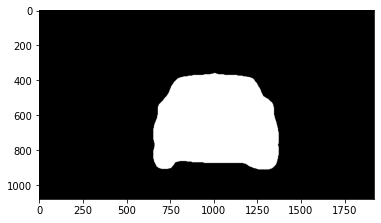

In [144]:
#plotting the binarized image
plt.imshow(threshold_img,cmap="gray")

In [145]:
#checking the dimesion of image
threshold_img.ndim

2

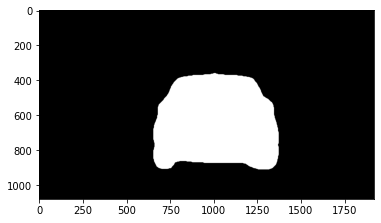

In [146]:
# now again converting threshold_img into RGB space
converted=cv2.cvtColor(threshold_img,cv2.COLOR_GRAY2BGR)
plt.imshow(converted)

In [147]:
# after applying color our segmented image values is limited to 0 to 255. 
np.unique(converted)

array([  0, 255], dtype=uint8)

In [148]:
white_background_image=np.full((original_image.shape),255,dtype=np.uint8)


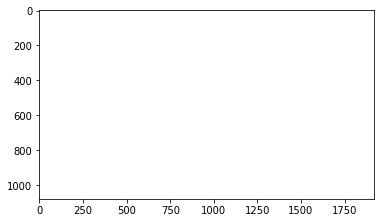

In [149]:
plt.imshow(white_background_image)

In [150]:
segmented_img=np.where(converted!=(0,0,0),original_image,white_background_image)

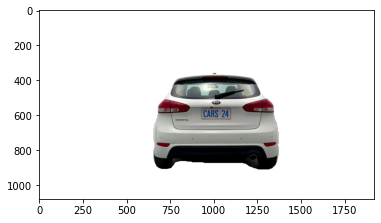

In [151]:
plt.imshow(segmented_img)

In [152]:
new_org=cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)
cv2.imwrite("output.jpg",new_org)

True

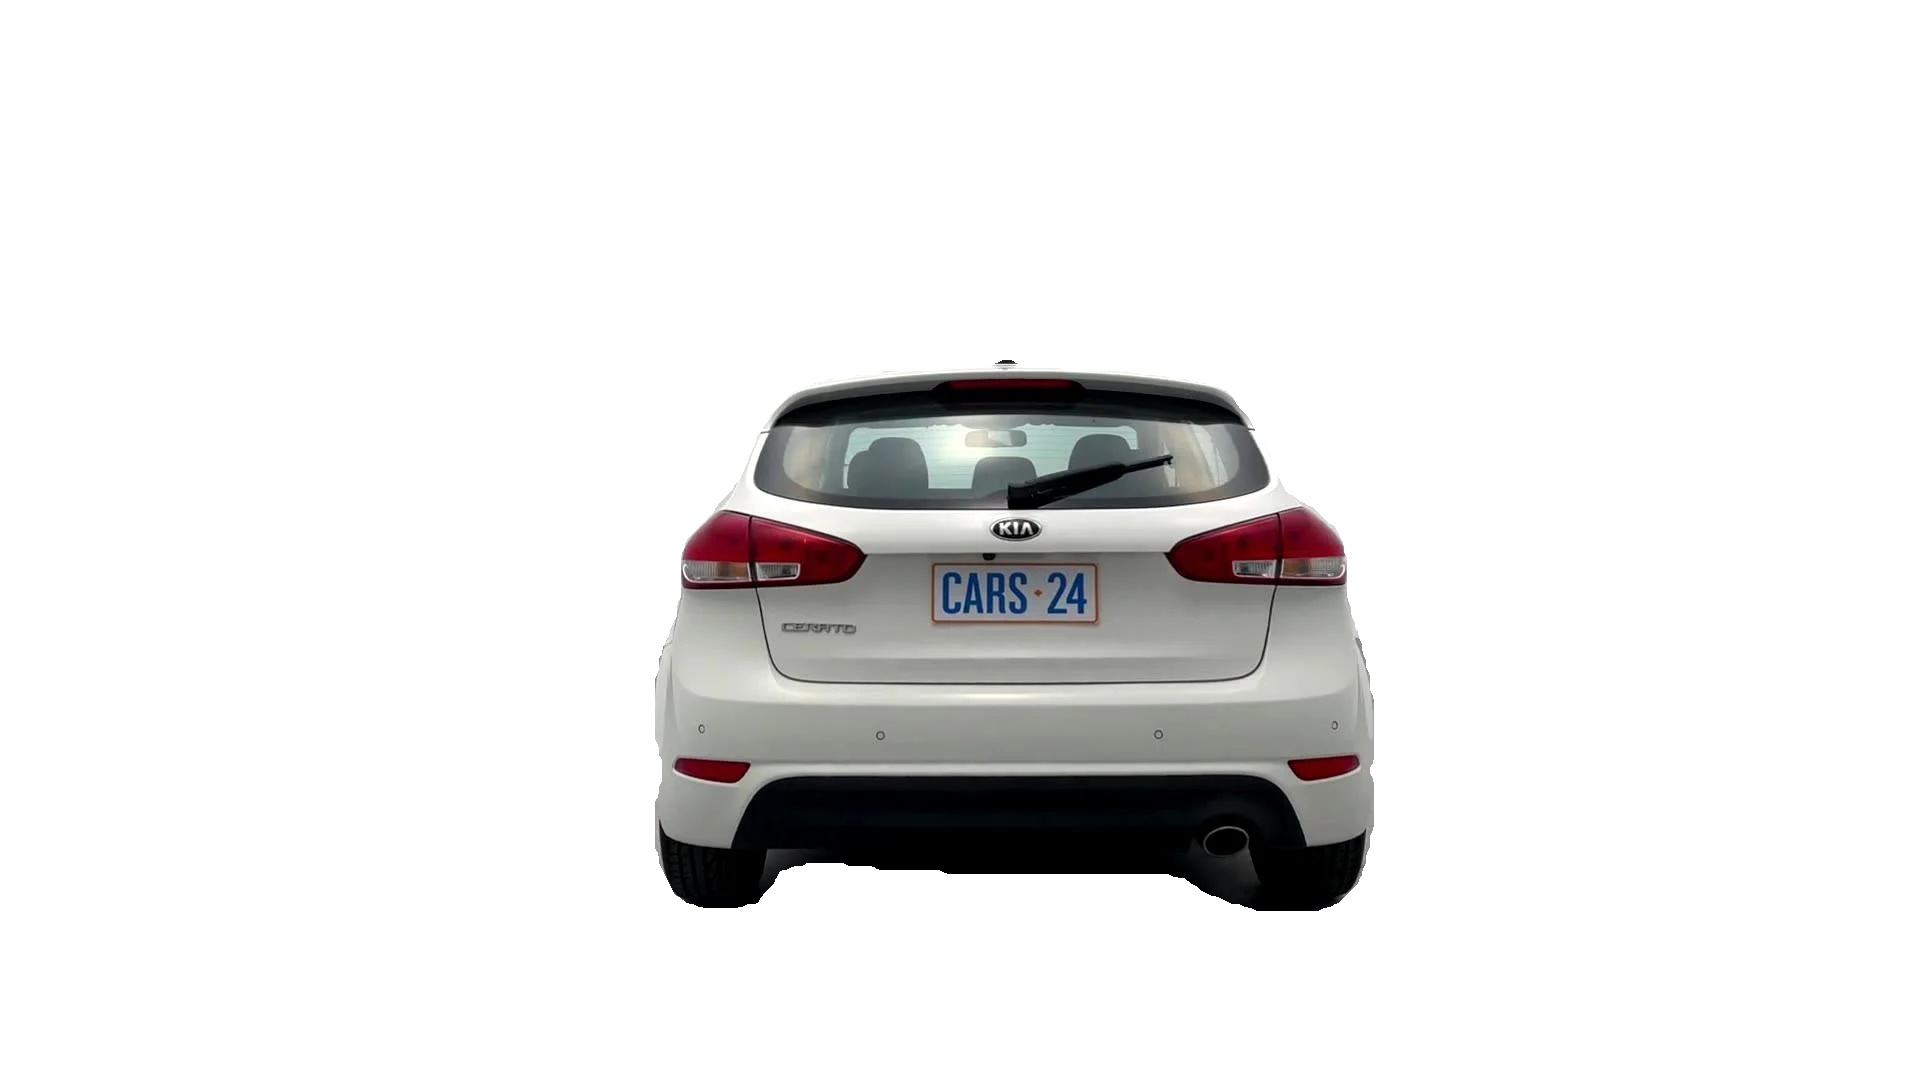

In [153]:
IMG("output.jpg")

In [155]:
'''sharpening the segmented image
image = cv2.imread('output.jpg', flags=cv2.IMREAD_COLOR)
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
cv2_imshow( image_sharp)'''



"sharpening the segmented image\nimage = cv2.imread('output.jpg', flags=cv2.IMREAD_COLOR)\nkernel = np.array([[0, -1, 0],\n                   [-1, 5,-1],\n                   [0, -1, 0]])\nimage_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)\ncv2_imshow( image_sharp)"